In [1]:
import torch

data = torch.load("../checkpoints/last.ckpt", map_location="cpu")

In [2]:
data["lr_schedulers"]

[{'step_size': 10,
  'gamma': 0.1,
  'base_lrs': [0.0001, 1e-05, 1e-05],
  'last_epoch': 1,
  'verbose': False,
  '_step_count': 2,
  '_get_lr_called_within_step': False,
  '_last_lr': [0.0001, 1e-05, 1e-05]}]

In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join("../src")))

In [2]:
from models.backbone import Backbone

backbone = Backbone(True, True, False, True, 4)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

In [3]:
from hydra import initialize, compose
import hydra

with initialize(version_base=None, config_path="../configs/"):
    cfg = compose(config_name="train.yaml", overrides=["model=deformable_detr"])

In [4]:
cfg

{'task_name': 'train', 'tags': ['dev'], 'train': True, 'test': True, 'ckpt_path': None, 'seed': 1, 'matmul_precision': 'high', 'model': {'_target_': 'models.deformable_detr_module.DeformableDETRModule', 'optimizer': {'lr': 0.0001, 'lr_backbone': 1e-05, 'lr_drop': 20, 'lr_gamma': 0.1, 'lr_linear_proj_mult': 0.1, 'weight_decay': 0.0001}, 'hybrid': {'k_one2many': 6, 'lambda_one2many': 1.0}, 'net': {'_target_': 'models.deformable_detr.build', 'num_classes': 12, 'with_box_refine': True, 'two_stage': True, 'frozen_weights': None, 'dilation': False, 'position_embedding': 'sine', 'position_embedding_scale': 6.28318530718, 'num_feature_levels': 4, 'enc_layers': 6, 'dec_layers': 6, 'dim_feedforward': 2048, 'hidden_dim': 256, 'dropout': 0.0, 'nheads': 8, 'num_queries_one2one': 300, 'num_queries_one2many': 1500, 'dec_n_points': 4, 'enc_n_points': 4, 'mixed_selection': True, 'look_forward_twice': True, 'use_checkpoint': False, 'aux_loss': True, 'set_cost_class': 2, 'set_cost_bbox': 5, 'set_cost_gio

In [5]:
from models.deformable_detr_module import DeformableDETRModule
import torch

In [6]:
model = hydra.utils.instantiate(cfg.model)
model = model.cuda()
checkpoint = torch.load("../checkpoints/last.ckpt")
model.load_state_dict(checkpoint["state_dict"])

InstantiationException: Error in call to target 'models.deformable_detr.build':
AttributeError("'Args' object has no attribute 'backbone'")
full_key: model.net

In [ ]:
def load_image(name):
    import cv2

    img = cv2.imread(f"../datasets/bdd100k/images/100k/val/{name}.jpg")
    img = img.transpose(2, 0, 1)[None, ...]
    img = torch.tensor(img).float().cuda()

    return img

In [ ]:
light_image = load_image("b1c9c847-3bda4659")
dark_image = load_image("b1c81faa-3df17267")

In [ ]:
def visualize_feature_map(feature_map):
    """
    Shape of feature map: (C, H, W)
    """
    import matplotlib.pyplot as plt

    row = 4
    col = 4

    plt.figure(figsize=(20, 10))

    for i in range(min(row * col, feature_map.shape[0])):
        plt.subplot(row, col, i + 1)
        plt.imshow(feature_map[i, :, :].cpu().detach().numpy())
        plt.axis("off")
    plt.show()

In [ ]:
light_output = model.backbone[0].body(light_image)
dark_output = model.backbone[0].body(dark_image)

In [ ]:
print(light_output["0"].shape)
print(light_output["1"].shape)
print(light_output["2"].shape)

torch.Size([1, 512, 90, 160])
torch.Size([1, 1024, 45, 80])
torch.Size([1, 2048, 23, 40])


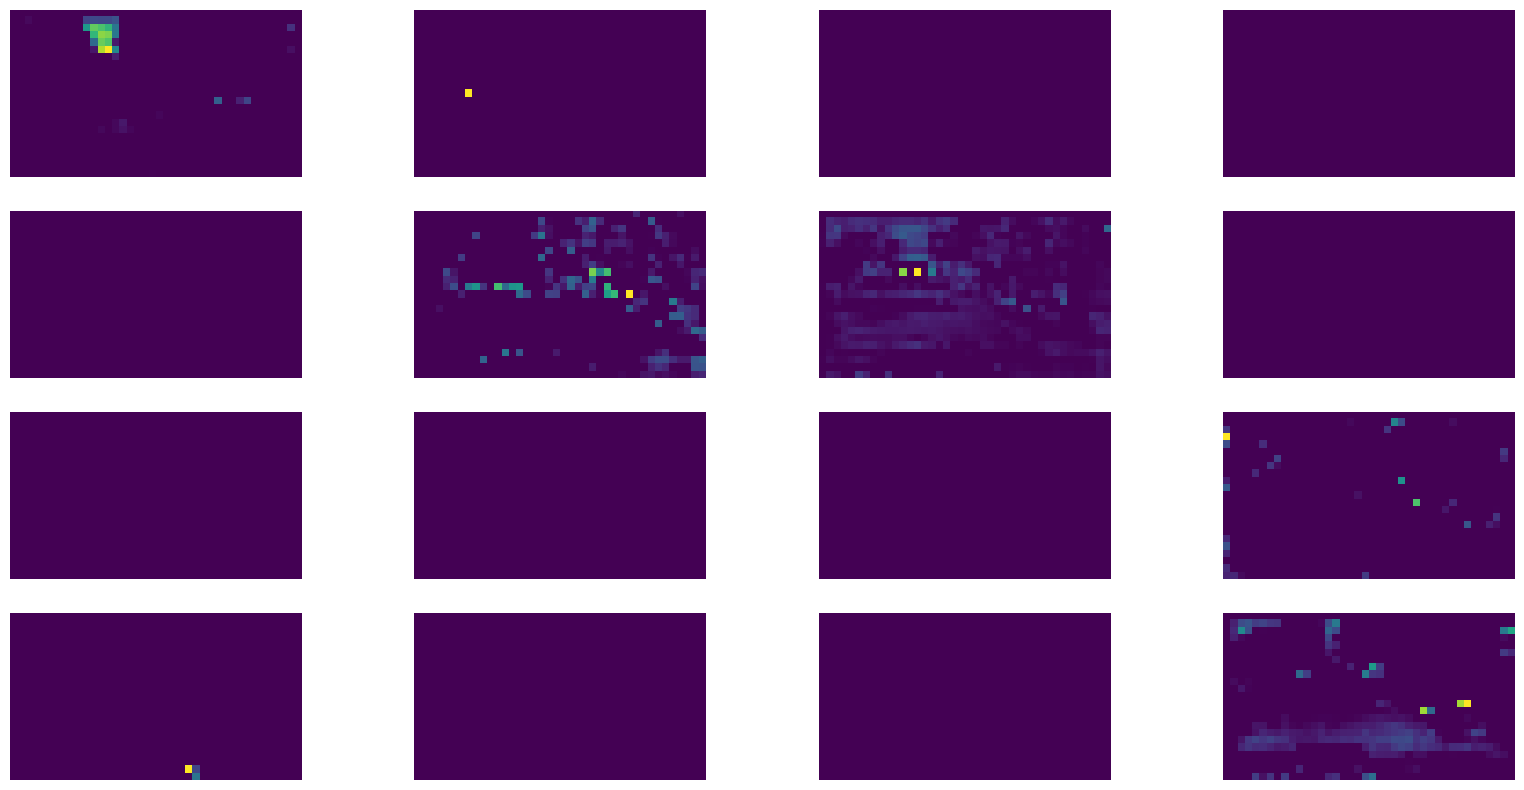

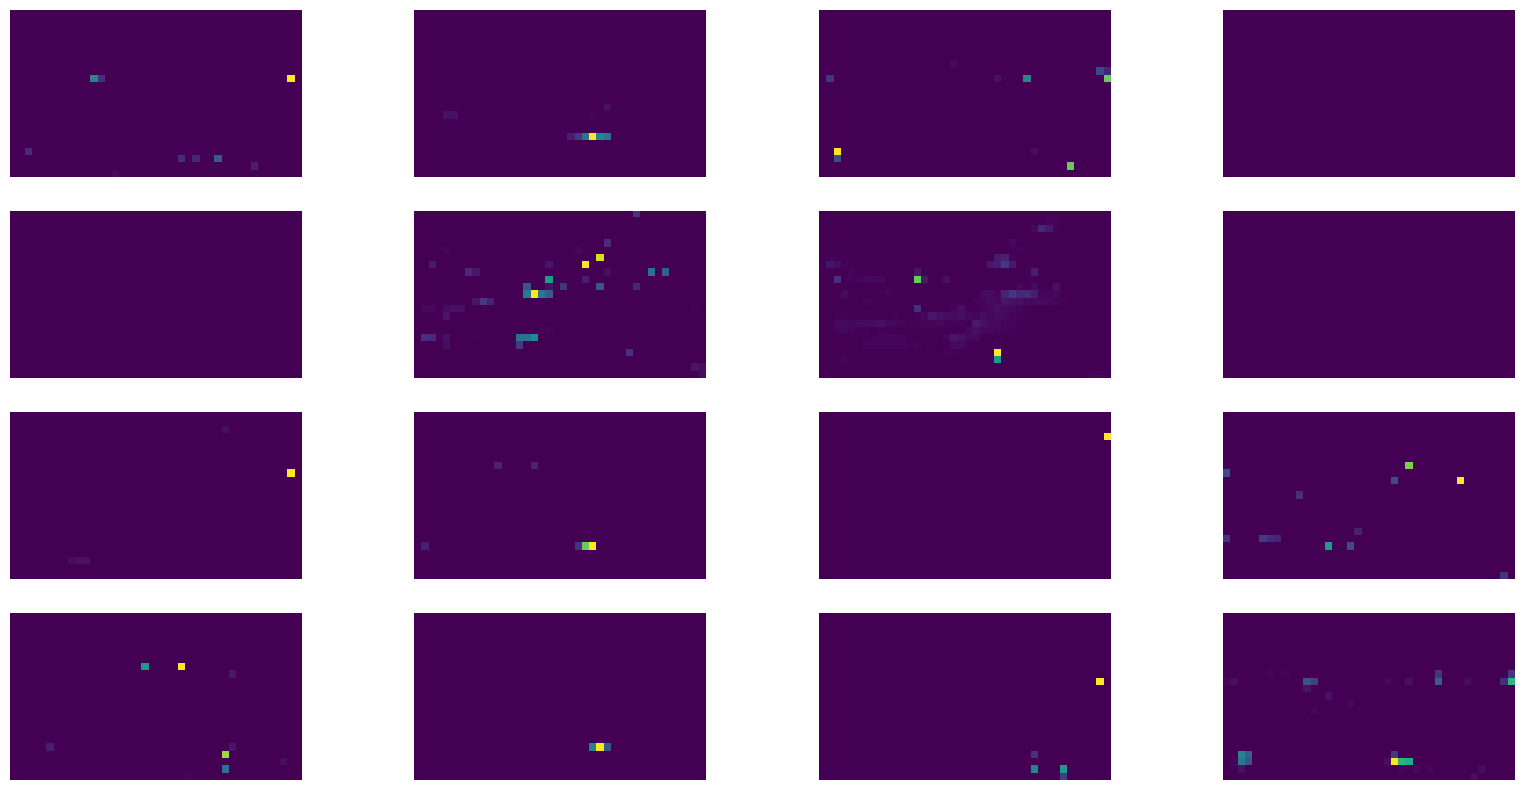

In [ ]:
visualize_feature_map(light_output["2"][0])
visualize_feature_map(dark_output["2"][0])

In [ ]:
from models.lla_cnn_block import LowLightApdaptiveCNNBlock

lla_cnn_block = LowLightApdaptiveCNNBlock(2048, 2048, 3, 1, 1, 2)

In [ ]:
lla_cnn_block.cuda()
output = lla_cnn_block(torch.rand(2, 2048, 32, 32).cuda())

output.shape

torch.Size([2, 2048, 32, 32])

In [ ]:
# number of parameters
{p[0]: p[1].numel() for p in lla_cnn_block.named_parameters()}

{'kernal_embed': 36864,
 'bias_embed': 4096,
 'bn.weight': 2048,
 'bn.bias': 2048,
 'cls_conv.weight': 18432,
 'cls_conv.bias': 2048,
 'cls_bn.weight': 2048,
 'cls_bn.bias': 2048,
 'cls_dense.weight': 4096,
 'cls_dense.bias': 2}

In [ ]:
sum(p.numel() for p in lla_cnn_block.parameters() if p.requires_grad)

73730

In [ ]:
from models.backbone import LLABackbone
from utils.misc import NestedTensor

In [ ]:
backbone = LLABackbone("resnet50", True, True, False, 2).cuda()

In [ ]:
backbone(
    NestedTensor(torch.rand(2, 3, 256, 256).cuda(), torch.rand(2, 256, 256).cuda())
)

{'0': tensor([[[[0.0318, 0.0318, 0.0318,  ..., 0.0318, 0.0318, 0.0318],
           [0.0318, 0.0318, 0.0318,  ..., 0.0318, 0.0318, 0.0318],
           [0.0318, 0.0318, 0.0318,  ..., 0.0318, 0.0318, 0.0318],
           ...,
           [0.0318, 0.0318, 0.0318,  ..., 0.0318, 0.0318, 0.0318],
           [0.0318, 0.0318, 0.0318,  ..., 0.0318, 0.0318, 0.0318],
           [0.0318, 0.0318, 0.0318,  ..., 0.0318, 0.0318, 0.0318]],
 
          [[0.3513, 0.3478, 0.3480,  ..., 0.0000, 0.0000, 0.2834],
           [0.3534, 0.3467, 0.3461,  ..., 0.2389, 0.0000, 0.2687],
           [0.0000, 0.0000, 0.0800,  ..., 3.0148, 0.0000, 0.3079],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.5883, 0.0181, 0.3434],
           [1.3107, 0.0000, 0.0000,  ..., 0.3457, 0.3440, 0.3435],
           [1.2566, 0.0000, 0.0000,  ..., 0.3545, 0.3522, 0.3481]],
 
          [[0.0203, 0.0000, 0.6780,  ..., 0.0000, 0.3553, 0.1088],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7493, 0.0000],
           [1.1704,